# DeepCube Use Case 3: Fire Hazard Forecasting in the Mediterranean

 ![use case3 icon](static/uc3-logo.png) 

# Notebook 1: Datacube access and basic analytics

This notebook shows basic utilities to load and process the [greece_wildfire_datacube](https://zenodo.org/deposit/4943354) with [xarray](http://xarray.pydata.org/en/stable/). 

It contains basic instructions showing how to access, process and visualize the data.

## Initial Imports

We start by importing the libraries we need. Make sure to have them installed in your system. 

In [1]:
import xarray as xr
import fsspec
import zarr

import numpy as np
import pandas as pd

import csv
import numpy as np
import matplotlib.pyplot as plt

import random
import os
from tqdm import tqdm
import gc
from pathlib import Path

## Download (optional) and access Datacube

We either download the datacube from [Zenodo](https://zenodo.org/record/4943354) in the form of a single netcdf file named `dataset_greece.nc`, or directly use the cloud-hosted version  of the datacube (access will be slower).

Then we open the datacube with xarray.

In [2]:
# First method (Download and access)
# !wget -O dataset_greece.nc https://zenodo.org/record/4943354/files/dataset_greece.nc?download=1
# ds = xr.open_dataset('./dataset_greece.nc')

# Second method (Use cloud-hosted datacube instance)
url = 'https://storage.de.cloud.ovh.net/v1/AUTH_84d6da8e37fe4bb5aea18902da8c1170/uc3/uc3cube.zarr'
ds = xr.open_zarr(fsspec.get_mapper(url), consolidated=True)

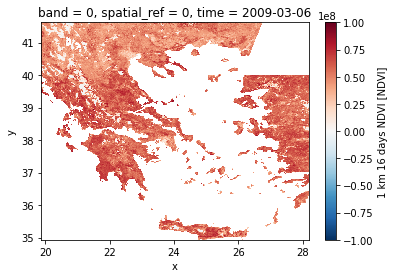

In [3]:
ds['1 km 16 days NDVI'][0].plot()

In [4]:
ds

<xarray.Dataset>
Dimensions:                  (time: 4314, x: 700, y: 562)
Coordinates:
    band                     int64 ...
    spatial_ref              (time) int64 dask.array<chunksize=(288,), meta=np.ndarray>
  * time                     (time) datetime64[ms] 2009-03-06 ... 2020-12-26
  * x                        (x) float64 19.86 19.87 19.89 ... 28.16 28.17 28.18
  * y                        (y) float64 41.62 41.61 41.59 ... 34.96 34.95 34.94
Data variables: (12/58)
    1 km 16 days EVI         (time, y, x) float64 dask.array<chunksize=(288, 50, 50), meta=np.ndarray>
    1 km 16 days NDVI        (time, y, x) float64 dask.array<chunksize=(288, 50, 50), meta=np.ndarray>
    1 km 16 days VI Quality  (time, y, x) float64 dask.array<chunksize=(288, 50, 50), meta=np.ndarray>
    ET_500m                  (time, y, x) float64 dask.array<chunksize=(288, 50, 50), meta=np.ndarray>
    ET_QC_500m               (time, y, x) float64 dask.array<chunksize=(288, 50, 50), meta=np.ndarray>
    FparExtra_QC             (time, y, x) float64 dask.array<chunksize=(288, 50, 50), meta=np.ndarray>
    ...                       ...
    population_density_2020  (y, x) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
    roads_density_2020       (y, x) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    slope_max                (y, x) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
    slope_mean               (y, x) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
    slope_min                (y, x) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
    slope_std                (y, x) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>

We see that the dataset has x,y and time dimensions.

More specifically it contains 4314 days (from 06/03/2009 to 06/12/2020) of 700x562 rasters

Dynamic variables like the `burned_areas` have all three dimensions, while static variables like `clc_2012` misses the temporal component and only has x, y dimensions.

In [5]:
import random
random.sample(list(range(10)), 10)

[1, 9, 2, 7, 8, 3, 0, 4, 5, 6]

## Plotting and Analytics

In this section, we'll see some basic functionality showing how to select and visualize the variables in the datacube.

Corine Land Cover 2012 (clc_2012) is a static dataset, containing Land Cover values . Let's see what it looks like

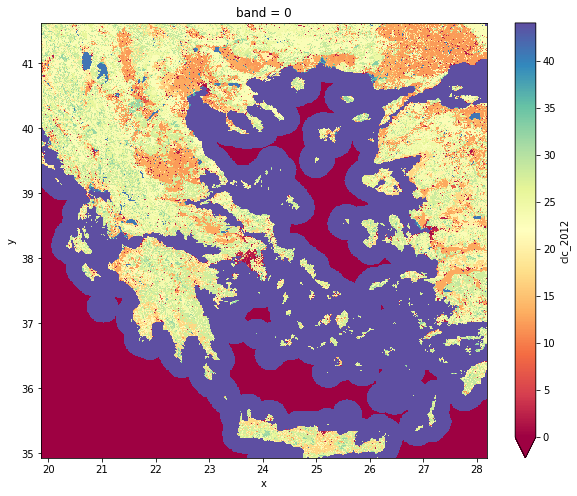

In [6]:
ds['clc_2012'].plot(cmap='Spectral', vmin=0, vmax=44, figsize=(10,8))

Maximum Temperature for a specific period of time for a specific pixel (300x300) in the dataset. We can plot both the time-series of the temperature and a histogram of the values

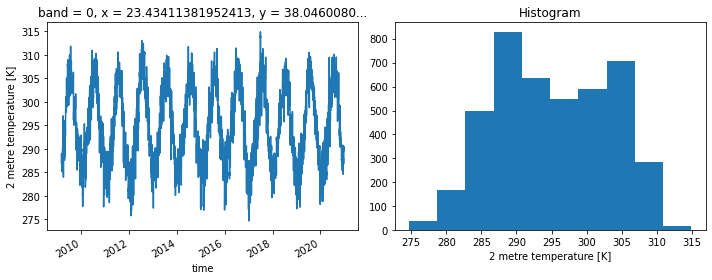

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
(ds['era5_max_t2m']).isel(x=300, y=300).plot(ax=axes[0])
(ds['era5_max_t2m']).isel(x=300, y=300).plot.hist(ax=axes[1])
plt.tight_layout()
plt.draw()

The same but only for year 2019

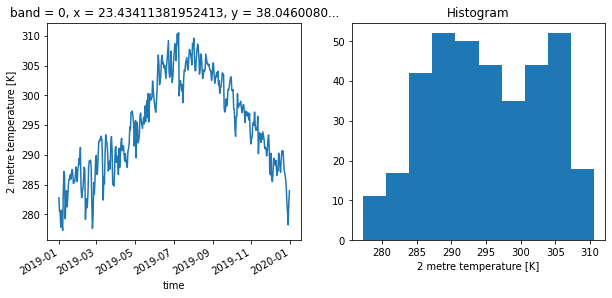

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
ds['era5_max_t2m'].sel(time=slice("2019-01-01", "2019-12-31")).isel(x=300, y=300).plot(ax=axes[0])
ds['era5_max_t2m'].sel(time=slice("2019-01-01", "2019-12-31")).isel(x=300, y=300).plot.hist(ax=axes[1])
plt.show()

A 10-rolling mean of the NDVI for a specific period of time and a specific pixel

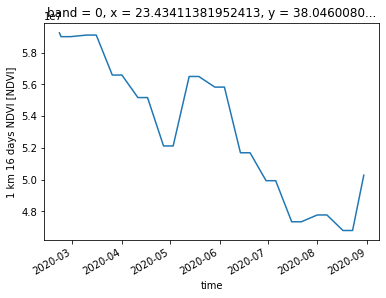

In [9]:
ds['1 km 16 days NDVI'].isel(dict(time=slice(4000, 4200), x=300, y=300)).rolling(time=10, center=True).mean().plot()

Plots of land surface temperature for a series of days for the whole Greece region

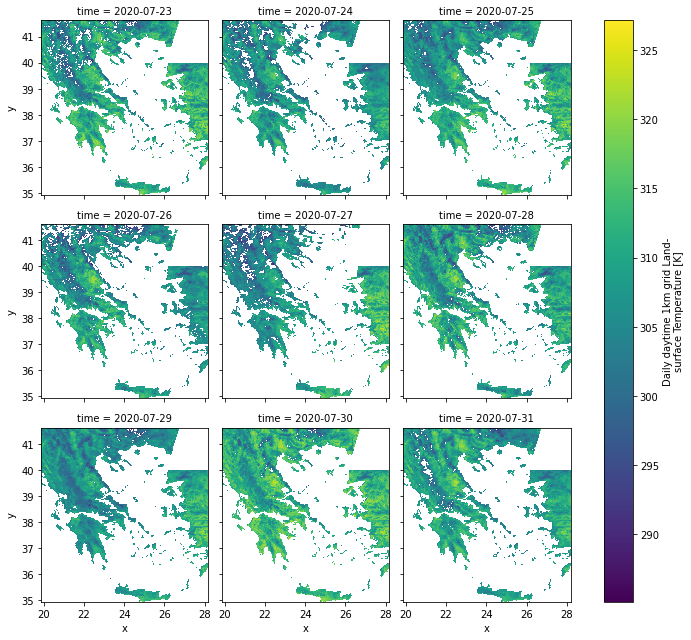

In [10]:
ds['LST_Day_1km'].isel(time=slice(4157, 4166)).plot(x="x", y="y", col="time", col_wrap=3)

We can plot the fire weather index for the same days

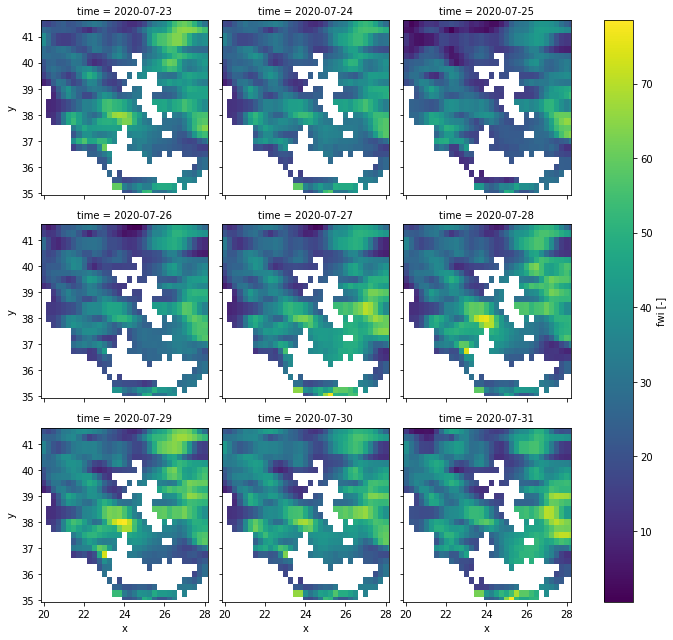

In [11]:
ds['fwi'].isel(time=slice(4157, 4166)).plot(x="x", y="y", col="time", col_wrap=3)

Or the burned areas from a fire that started those days

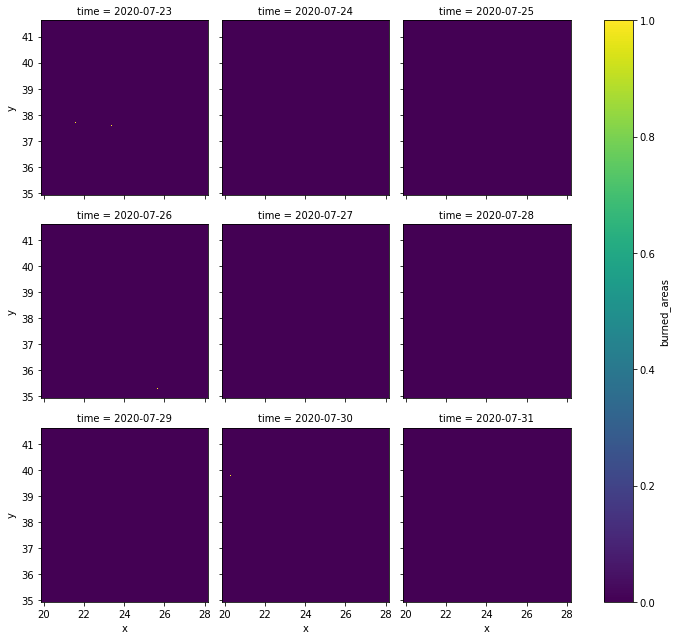

In [12]:
ds['burned_areas'].isel(time=slice(4157, 4166)).plot(x="x", y="y", col="time", col_wrap=3)

Just a few pixels of burned areas and a complex interaction of the fire drivers. It is going to be quite challenging to model that... Stay tuned for our first models in the next notebooks that we will publish.

# Discussion

We saw how easy it is to access, process and visualize data in the datacube, even if the actual data is very large and cannot be loaded in memory.

In a later notebook we'll see how to develop some ML models using our datacube to predict the burnt area from next day's fire. Stay tuned!

# Acknowledgements

Research funded by the EU H2020 project DeepCube ’Explainable AI pipelines for big Copernicus data’, grant agreement No 101004188.

Notebook Authors: *Ioannis Prapas (https://github.com/iprapas), Spyros Kondylatos (https://github.com/skondylatos)*